# 模板匹配

# 1. 模板匹配简介

① 模板匹配和卷积原理很像，模板在原图像上从原点开始滑动，计算模板与（图像被模板覆盖的地方）的差别程度(例如值127与值190的区别)，这个差别程度的计算方法在opencv里有6种，然后将每次计算的结果放入一个矩阵里，作为结果输出。

② 假如原图形是AxB大小，而模板是axb大小，则输出结果的矩阵是(A-a+1)x(B-b+1)。

③ 模板匹配计算方式6种方式 ( 用归一化后的方式更好一些 )：

- TM_SQDIFF：计算平方不同，计算出来的值越小，越相关。        
- TM_CCORR：计算相关性，计算出来的值越大，越相关。
- TM_CCOEFF：计算相关系数，计算出来的值越大，越相关。
- TM_SQDIFF_NORMED：计算归一化平方不同，计算出来的值越接近0，越相关。
- TM_CCORR_NORMED：计算归一化相关性，计算出来的值越接近1，越相关。
- TM_CCOEFF_NORMED：计算归一化相关系数，计算出来的值越接近1，越相关。

④ 公式：https://docs.opencv.org/3.3.1/df/dfb/group__imgproc__object.html#ga3a7850640f1fe1f58fe91a2d7583695d

# 计算机视觉：模板匹配 (Template Matching) 深度解析

这段文字描述了计算机视觉中非常经典的 **“模板匹配”** 技术。它的本质就像是在玩“大家来找茬”，拿一张小图（模板）在大图里到处比对，寻找最像的地方。

---

## 1. 核心原理：滑动窗口与对比

* **原理：** 想象你拿着一张透明的小照片（模板 $T$），在大照片（图像 $I$）上从左上角开始，一个像素一个像素地向右、向下移动。每移动到一个位置，就计算一下这张小图和它盖住的那块区域到底“长得有多像”。
* **卷积与匹配的区别：** * **卷积**：是为了提取特征（如边缘）。
    * **模板匹配**：是为了寻找完全一致的区域。



---

## 2. 输出矩阵大小的数学逻辑

**公式：** $(A - a + 1) \times (B - b + 1)$

**为什么不是原来的大小？**
假设大图宽 $5$ 像素，小图宽 $3$ 像素：
1.  当小图的左边缘在第 $1$ 个像素时，它占用了 $\{1, 2, 3\}$。
2.  当小图的左边缘在第 $2$ 个像素时，它占用了 $\{2, 3, 4\}$。
3.  当小图的左边缘在第 $3$ 个像素时，它占用了 $\{3, 4, 5\}$。

> **注意：** 小图不能再往右移了，否则它的右边就会超出大图边界。所以在宽度方向上，你只能得到 $5 - 3 + 1 = 3$ 个计算结果。高度同理。

---

## 3. 六种计算方式的数学深度解析

公式中的数学表达式其实是在描述 **“距离”** 或 **“相关性”**。

### A. 平方差系列 (SQDIFF) —— 算“距离”
* **公式逻辑**：$R(x,y) = \sum_{x',y'} (T(x',y') - I(x+x', y+y'))^2$
* **物理含义**：就像计算两点间的距离。如果两张图一模一样，差值就是 $0$，平方和也是 $0$。
* **结论**：值越小越好。

### B. 相关性系列 (CCORR) —— 算“重合度”
* **公式逻辑**：$R(x,y) = \sum_{x',y'} (T(x',y') \cdot I(x+x', y+y'))$
* **物理含义**：这是一个向量点积的概念。在数学上，两个向量越接近，它们的点积就越大。
* **结论**：值越大越好。（但它对亮度非常敏感，一张全白的图可能会得到很高的分）。

### C. 相关系数系列 (CCOEFF) —— 算“规律相似度”
* **公式逻辑**：会先减去各自的平均值 $\bar{T}$ 和 $\bar{I}$ 再计算。
* **物理含义**：它不看绝对亮度，看的是像素变化的“趋势”。即使大图很暗，模板很亮，只要它们的图形特征一致，得分就会很高。
* **结论**：值越大越好。这是最鲁棒（准确）的方法。

---

## 4. 为什么要“归一化 (NORMED)”？

* **如果不归一化**：如果你在比较一个很亮的区域和一个很暗的区域，由于亮度值本身很大（比如 $255$），计算出的相关性结果会非常巨大，导致你无法判断这个高分是因为“长得像”还是因为“单纯比较亮”。
* **归一化之后**：它把所有的结果映射到了 $[0, 1]$ 之间。
    * **SQDIFF_NORMED**：完美的匹配是 $0$。
    * **CCORR_NORMED / CCOEFF_NORMED**：完美的匹配是 $1$。

**建议**：在实际工程中，通常首选 `TM_CCOEFF_NORMED`。虽然计算量稍微大一点，但它对光照变化不敏感，结果最直观（$1$ 就是 $100\%$ 像）。

---

## 5. 总结：如何看懂官方文档的公式？

当你看到文档里那些复杂的 $\sum$ 符号时，记住这三个关键符号：
1.  $T(x', y')$：模板图像在某个点的值。
2.  $I(x+x', y+y')$：大图里被模板盖住的那个对应点的值。
3.  $R(x, y)$：最后输出矩阵中坐标为 $(x, y)$ 处的值，代表在这个位置的匹配得分。

**一句话总结：模板匹配就是通过数学公式，把“长得像不像”转换成一个可以比较的数字。**

# 2. 模板匹配单个对象

In [15]:
import cv2 #opencv的缩写为cv2
import matplotlib.pyplot as plt # matplotlib库用于绘图展示
import numpy as np   # numpy数值计算工具包

# 魔法指令，直接展示图，Jupyter notebook特有
%matplotlib inline  

def img_show(img,name):
    cv2.imshow(name,img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

template = cv2.imread('01_Picture/12_Face.jpg', 0 )  # 0 表示以灰度图方式读取
img_show(template,'01')
img = cv2.imread('01_Picture/13_Lena.jpg',0) 
img_show(img,'02')
h, w = template.shape[:2] # 获得模板的宽和高

print(img.shape)
print(template.shape)

(263, 263)
(110, 85)


In [16]:
methods = ['cv2.TM_CCOEFF','cv2.TM_CCOEFF_NORMED','cv2.TM_CCORR',
          'cv2.TM_CCORR_NORMED','cv2.TM_SQDIFF','cv2.TM_SQDIFF_NORMED']
res = cv2.matchTemplate(img, template, cv2.TM_SQDIFF)
print(res.shape) # 返回的矩阵大小 (A-a+1)x(B-b+1)
min_val,max_val,min_loc,max_loc = cv2.minMaxLoc(res) # 返回模板匹配后最小值、最大值的位置   
print(min_val) # cv2.TM_SQDIFF方法中，越小的值表示像素点的差异越小
print(max_val)
print(min_loc) # 当获得最小值对应的模板左上角的位置，加上模板自身的长、宽，可以在原图像中画出最匹配的区域
print(max_loc)

(154, 179)
39168.0
74403584.0
(107, 89)
(159, 62)


4


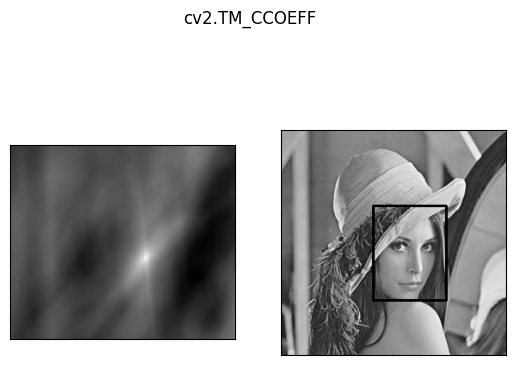

5


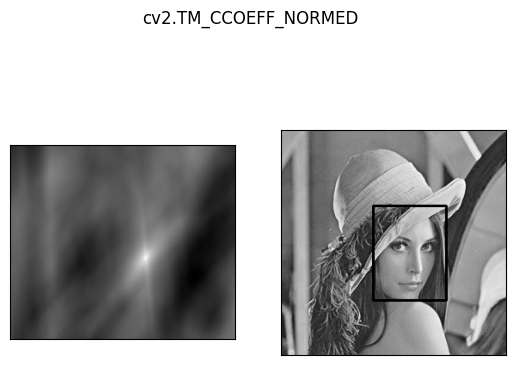

2


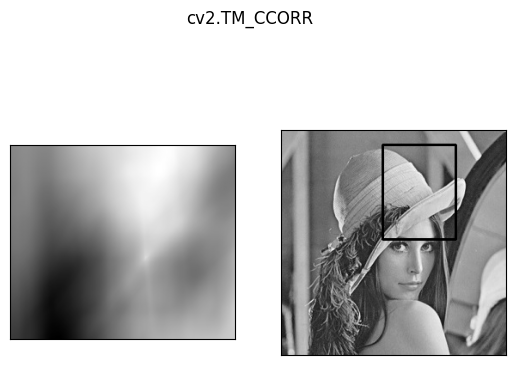

3


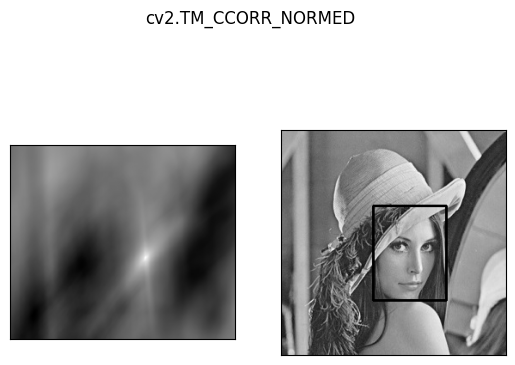

0


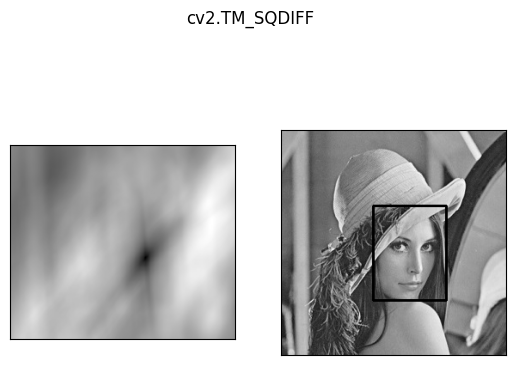

1


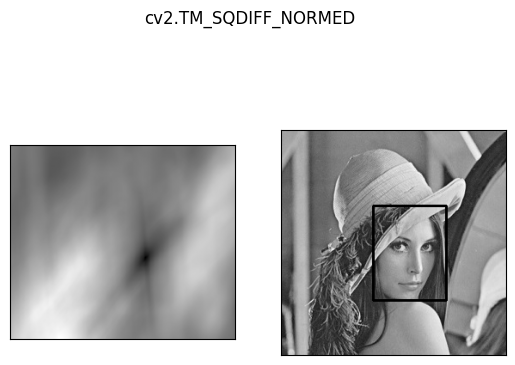

In [17]:
# 遍历预设的匹配方法列表（例如 methods = ['cv2.TM_CCOEFF_NORMED', 'cv2.TM_SQDIFF', ...])
for meth in methods:
    # 【语法】对象的深拷贝 (Deep Copy)
    # 【作用】由于 cv2.rectangle 会直接修改原始数组，copy() 保证每个方法都在初始图上操作，互不干扰
    img2 = img.copy()
    
    # 【语法】evl() 解a析字符串并执行对应的 Python 表达式
    # 【作用】将字符串（如 "cv2.TM_CCOEFF"）转换为 OpenCV 内部定义的整数常量（如 4）
    # 【参数】meth: 循环中的方法名字符串；返回的 method 为具体算法标识符
    method = eval(meth) 
    print(method)
    
    # 【语法】cv2.matchTemplate(image, templ, method) -> result
    # 【作用】核心匹配函数。在大图 img 上滑动模板 template，计算对应区域的相似度得分
    # 【参数】img: (H, W) 待搜寻图像；template: (h, w) 模板图像；method: 匹配算法类型
    # 【维度】输出 res 的维度为 (H - h + 1, W - w + 1)。每个像素值代表该位置与模板的匹配分数
    res = cv2.matchTemplate(img, template, method)
    
    # 【语法】cv2.minMaxLoc(src) -> minVal, maxVal, minLoc, maxLoc
    # 【作用】从结果矩阵 res 中检索出全局最小值、最大值及其对应的二维坐标 (x, y)
    # 【维度】min_loc 和 max_loc 返回的是 (x坐标, y坐标) 元组，对应图像的 (列, 行)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    # 【逻辑判断】根据算法特性选择坐标点
    # 【作用】对于“平方差”类算法，数值越小(0)越匹配，取 min_loc；其余算法数值越大越匹配，取 max_loc
    # 【参数】cv2.TM_SQDIFF 和 cv2.TM_SQDIFF_NORMED 是特殊的“值越小越好”算法
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc  # 确定匹配区域的左上角 (x, y)
    else:
        top_left = max_loc
    
    # 【语法】元组坐标运算
    # 【作用】利用左上角坐标加上模板的宽度 w 和高度 h，推导出矩形框的右下角坐标
    # 【参数】top_left[0] 是横向偏移(x)，top_left[1] 是纵向偏移(y)
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    # 【语法】cv2.rectangle(img, pt1, pt2, color, thickness)
    # 【作用】在复制的图像 img2 上绘制矩形边框
   
    cv2.rectangle(img2, top_left, bottom_right,(0,255,0), 2)   #因为是灰度图，所有颜色值只取第一个
    
    # 【语法】plt.subplot(行, 列, 索引)
    # 【作用】创建一个 1 行 2 列的展示窗口，并定位到第 1 个子图
    # 【参数】imshow(res): 显示匹配得分的热力图，越亮的地方表示匹配概率越高（或越低，视算法而定）
    plt.subplot(121), plt.imshow(res, cmap='gray')
    plt.xticks([]), plt.yticks([]) # 隐藏坐标轴刻度，优化视觉效果
    
    # 【作用】定位到第 2 个子图，显示带检测框的识别结果
    plt.subplot(122), plt.imshow(img2, cmap='gray')
    plt.xticks([]), plt.yticks([])
    
    # 【语法】plt.suptitle(t)
    # 【作用】为当前弹出的整个 Matplotlib 窗口设置总标题，显示当前正在执行的匹配方法名
    plt.suptitle(meth)
    
    # 【作用】将绘图缓存渲染到屏幕并暂停程序，等待用户关闭窗口后继续下一次循环
    plt.show()

# 3. 模板匹配多个对象

In [24]:
# 【语法】cv2.imread(path) 加载图片，默认 BGR 彩色模式
# 【作用】读取大图，用于最后的绘制和展示
# 【维度】img_rgb: (H, W, 3)，3 代表彩色三通道
img_rgb = cv2.imread('01_Picture/14_Mario.jpg')

# 【语法】cv2.cvtColor(src, code) 颜色空间转换
# 【作用】将彩色图转为灰度图，因为匹配算法在单通道下计算速度更快且更稳定
# 【维度】img_gray: (H, W)，从 3 通道降为 1 通道
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
print('img_gray.shape：', img_gray.shape)

# 【语法】cv2.imread(path, 0) 参数 0 表示以灰度模式读取
# 【作用】准备模板小图（金币）
# 【维度】template: (h, w)，单通道灰度图
template = cv2.imread('01_Picture/15_Mario_coin.jpg', 0)
print('template.shape：', template.shape)

# 【语法】Python 切片获取前两个元素
# 【作用】提取模板的高 h 和宽 w，用于后续绘制矩形框
h, w = template.shape[:2]

# 【语法】cv2.matchTemplate(image, templ, method) -> res
# 【作用】执行归一化相关系数匹配。res 矩阵存储了每个滑动窗口位置的“得分”（0 到 1）
# 【维度】res: (H-h+1, W-w+1)。H, W 是大图尺寸，h, w 是模板尺寸
res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
print('res.shape：', res.shape)

# 【作用】设定相似度阈值。只有得分超过 0.8 的区域才会被认为是匹配成功
threshold = 0.8

# 【语法】np.where(condition) 返回符合条件的索引坐标
# 【作用】找出 res 矩阵中所有得分大于等于 0.8 的位置
# 【参数/维度】loc 是一个元组，包含两个 array：loc[0] 是所有匹配点的行索引(y)，loc[1] 是列索引(x)
loc = np.where(res >= threshold) 
print('type(loc):', type(loc)) 
print('len(loc):', len(loc)) 

# 【维度深度解析】
# 假设找到了 120 个点，loc[0] 是长为 120 的 y 坐标数组，loc[1] 是长为 120 的 x 坐标数组
print('len(loc[0]):', len(loc[0]), 'len(loc[1]):', len(loc[1])) 
print('type(loc[0]):', type(loc[0]), 'type(loc[1]):', type(loc[1])) 

# 【语法】切片反转 [::-1]
# 【作用】将 (y_array, x_array) 变为 (x_array, y_array)。因为 OpenCV 绘图坐标要求是 (x, y)
print("loc[::-1]：", loc[::-1]) 

i = 0
# 【语法】*loc[::-1] 是参数解包；zip 将对应的 x 和 y 重新组合成坐标对
# 【作用】将两个独立的坐标数组打包成一个个具体的点坐标 pt，如 (x1, y1), (x2, y2)...
# 【维度】pt 是一个包含两个数值的元组 (x, y)

for pt in zip(*loc[::-1]):   # *loc[::-1] 等于解包两个数组 ax,ay
    # 【参数】pt[0] 是左上角 x，pt[1] 是左上角 y
    # 【作用】计算匹配区域的右下角坐标，用于画框
    bottom_right = (pt[0] + w, pt[1] + h)
    # 【语法】cv2.rectangle(img, pt1, pt2, color, thickness)
    # 【作用】在彩色原图 img_rgb 上画红色矩形框（因为 img_rgb 是 3 通道，所以支持 (0,0,255) 红色）
    # 【参数】(0,0,255) 是 BGR 颜色，2 是线条像素宽度
    cv2.rectangle(img_rgb, pt, bottom_right, (0, 0, 255), 2)
    i = i + 1

# 【作用】统计一共圈出了多少个匹配目标（即金币数量）
print('i:', i)

# 【语法】cv2.imshow(winname, mat) 弹出窗口显示图像
cv2.imshow('img_rgb', img_rgb)

# 【语法】0 表示无限等待，直到用户按下任意键
cv2.waitKey(0)

img_gray.shape： (207, 225)
template.shape： (27, 16)
res.shape： (181, 210)
type(loc): <class 'tuple'>
len(loc): 2
len(loc[0]): 120 len(loc[1]): 120
type(loc[0]): <class 'numpy.ndarray'> type(loc[1]): <class 'numpy.ndarray'>
loc[::-1]： (array([ 69,  70,  83,  84,  97,  98, 111, 112, 125, 126,  68,  69,  70,
        82,  83,  84,  96,  97,  98, 110, 111, 112, 124, 125, 126,  68,
        69,  70,  82,  83,  84,  96,  97,  98, 110, 111, 112, 125, 126,
        69,  83,  97, 111, 125,  54,  55,  69,  83,  84,  97,  98, 111,
       112, 125, 126, 139, 140,  54,  55,  56,  68,  69,  70,  82,  83,
        84,  96,  97,  98, 110, 111, 112, 124, 125, 126, 138, 139, 140,
        54,  55,  56,  68,  69,  70,  82,  83,  84,  96,  97,  98, 110,
       111, 112, 124, 125, 126, 139, 140,  55,  69,  83,  97, 111, 125,
       139,  55,  55,  69,  83,  97, 111, 125, 139,  55,  69,  83,  97,
       111, 125, 139]), array([ 40,  40,  40,  40,  40,  40,  40,  40,  40,  40,  41,  41,  41,
        41,  41,  41,

-1